# 特征筛选

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import scipy
import sklearn
import re
import sys
import random
# 方差
from sklearn.feature_selection import VarianceThreshold
# 相关性过滤
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# 皮尔逊相关系数
from scipy.stats import pearsonr
from collections import OrderedDict
# 使用决策树筛选特征
from sklearn import tree
# 互信息法
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import SelectKBest,chi2
from my_tools import *
import warnings
warnings.filterwarnings("ignore")

### 读取数据

In [2]:
jibing = pd.read_excel("./jibing_yuchuli_final.xlsx")
jibing.shape

(1598, 63)

### 消去方差为 0 的属性

In [3]:
selector = VarianceThreshold() #实例化，不填参数默认方差为0
jibing_var0 = selector.fit_transform(jibing) #获取删除不合格特征之后的新特征矩阵
jibing_var0.shape

(1598, 63)

In [4]:
jibing.head()

,左右,是否外伤,症状持续时间,明显夜间痛,性别,年龄,高血压,高血脂,2型糖尿病,吸烟与否,...,果糖胺,肌酸激酶,α-L-盐藻糖苷酶,乳酸,淀粉酶,同型半胱氨酸,铁,总铁结合力,血型,结果
0,0,0,3,0,0,65,1,0,0,0,...,1.32,48.0,12.0,1.9,49.0,9.9,12.3,43.5,3,0
1,1,1,2,0,0,62,1,0,0,0,...,1.67,77.0,16.0,1.4,81.0,9.2,16.9,55.5,0,1
2,1,0,4,1,0,55,0,0,0,0,...,1.86,78.0,22.0,1.9,89.0,9.9,7.0,51.4,0,1
3,1,0,3,0,0,60,0,0,0,0,...,1.68,92.0,12.0,1.4,69.0,9.3,15.8,53.0,0,0
4,0,1,3,0,0,61,0,0,0,0,...,1.60,58.0,14.0,1.7,153.0,8.1,13.2,45.9,0,1


### 相关性分析

#### 皮尔逊相关系数

In [5]:
col = jibing.columns.tolist()
col.remove("结果")

In [6]:
dict_ = dict()
feature_ls = []
for col_ in col:
    corr, p = pearsonr(jibing["结果"], jibing[col_])
    """
        p > 0.05 才会有统计学意义
        所以这里将 p > 0.05 的特征放到一个字典中
        查看他们与结果的相关性
    """
    if p > 0.05:
        feature_ls.append(col_)
        dict_[col_] = abs(corr)

In [7]:
len(dict_)

59

In [8]:
feature_ls

['左右',
 '症状持续时间',
 '明显夜间痛',
 '性别',
 '年龄',
 '高血压',
 '高血脂',
 '2型糖尿病',
 '吸烟与否',
 '饮酒与否',
 '红细胞计数*10^12/L',
 '血红蛋白',
 '红细胞压积',
 '血小板计数',
 '血小板压积',
 '总蛋白g/L',
 '白蛋白g/L',
 '球蛋白g/L',
 '白球比',
 'ALT丙氨酸氨基转移酶',
 'AST天门冬氨酸氨基转移酶',
 '碱性磷酸酶',
 '谷氨酸转肽酶',
 'AST:ALT',
 '总胆红素',
 '直接胆红素',
 '间接胆红素',
 '钾',
 '钠',
 '氯',
 '钙',
 '磷',
 '镁',
 '葡萄糖',
 '尿素',
 '尿酸',
 '甘油三酯',
 '总胆固醇',
 'H高密度胆固醇',
 'L低密度胆固醇',
 '载脂蛋白A1',
 '载脂蛋白B',
 '载脂蛋白E mg/l',
 'aPoB/aPoA1',
 '脂蛋白小a',
 '乳酸脱氢酶LDH',
 'β-2微球蛋白',
 '胆碱酯酶',
 '前白蛋白mg/l',
 '总胆汁酸',
 '腺苷脱氨酶ADA',
 '果糖胺',
 '肌酸激酶',
 'α-L-盐藻糖苷酶',
 '淀粉酶',
 '同型半胱氨酸',
 '铁',
 '总铁结合力',
 '血型']

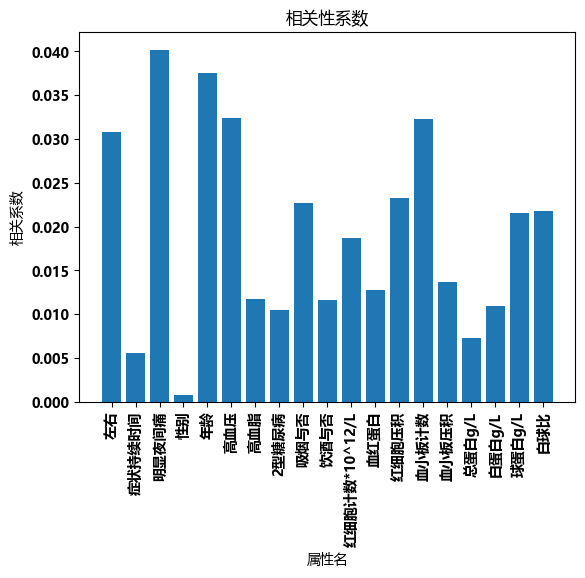

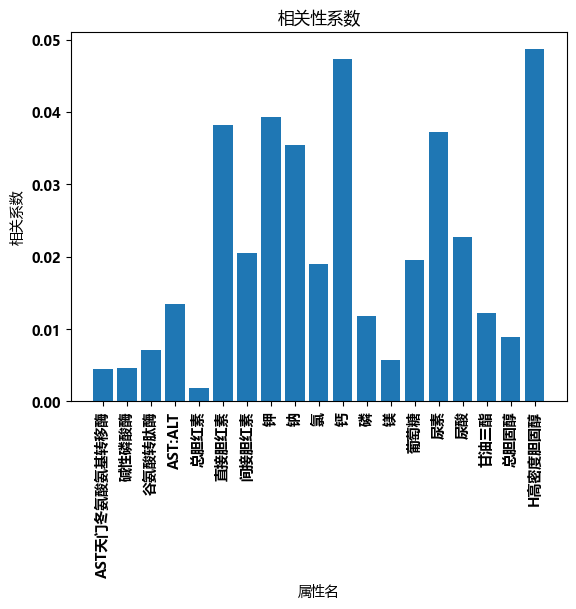

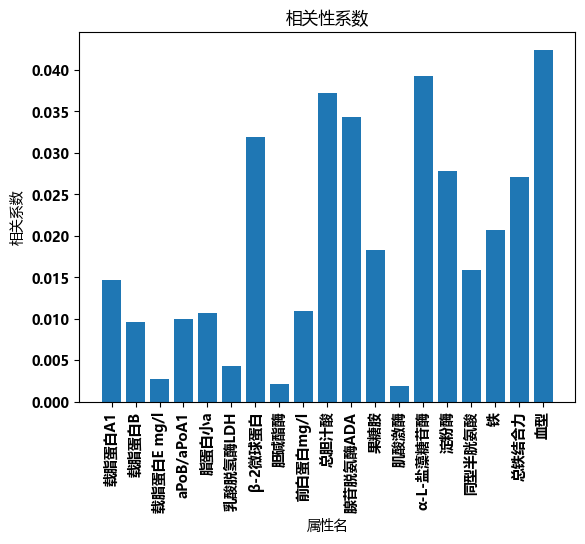

In [9]:
# 设置字体
set_font()
start = 0
end = 19
for i in range(3):
    # 使用自定义字体
    show_x = list(dict_.keys())[start:end]
    show_y = list(dict_.values())[start:end]
    plt.xlabel('属性名')
    plt.ylabel('相关系数')
    # 绘制柱状图
    plt.bar(show_x, show_y)
    # 显示图形
    start = start + 20
    end = end + 20
    plt.xticks(rotation=90)
    plt.title("相关性系数")
    plt.show()

### 使用决策树筛选特征

In [10]:
clf = tree.DecisionTreeClassifier(random_state=30)
clf = clf.fit(jibing.iloc[:,:-1],jibing.iloc[:,-1])

### 获取特征的重要性
#### 根据决策树的某些系数划分重要程度

In [11]:
tree_importance = clf.feature_importances_
tree_importance

array([0.00642058, 0.00428039, 0.00499379, 0.02252402, 0.        ,
       0.01654977, 0.01911454, 0.        , 0.        , 0.        ,
       0.        , 0.03454957, 0.00667023, 0.0113456 , 0.02181291,
       0.008653  , 0.0320874 , 0.06006682, 0.02659235, 0.02146013,
       0.00285359, 0.        , 0.01941168, 0.01444173, 0.02098024,
       0.00456575, 0.02118258, 0.00256741, 0.01527166, 0.01516202,
       0.02008489, 0.00494003, 0.        , 0.01235312, 0.03628761,
       0.02015343, 0.02685477, 0.03634301, 0.01141437, 0.03151978,
       0.01307189, 0.00508406, 0.01698537, 0.00808379, 0.01866136,
       0.02006391, 0.0165685 , 0.03874059, 0.01265598, 0.02484254,
       0.01521916, 0.0041057 , 0.01748961, 0.0339876 , 0.00445256,
       0.01425327, 0.02496806, 0.01092751, 0.01736746, 0.05684635,
       0.01211596, 0.        ])

### 由于特征是比较少的，所以将皮尔逊系数和决策树特征重要性放到一起考虑

In [12]:
# 确定一会儿要删除的特征
# 把它们放到drop_list中
drop_list = []

In [13]:
# 获取重要性为0的特征
indexes = [i for i, x in enumerate(tree_importance) if x == 0]

In [14]:
indexes

[4, 7, 8, 9, 10, 21, 32, 61]

In [15]:
for index in indexes:
    if dict_[col[index]] < 0.01:
        drop_list.append(col[index])
drop_list

['性别', 'AST天门冬氨酸氨基转移酶']

### 将无关属性去掉

In [16]:
jibing.shape

(1598, 63)

In [17]:
type(jibing)

pandas.core.frame.DataFrame

In [18]:
for name in drop_list:
    jibing.drop(name, axis=1,inplace = True)

In [19]:
jibing.shape

(1598, 61)

### 特征和结果分开

In [20]:
jibing_res = jibing.iloc[:,-1]
jibing_res.head()

0    0
1    1
2    1
3    0
4    1
Name: 结果, dtype: int64

In [21]:
jibing = jibing.iloc[:,:-1]
jibing.head()

,左右,是否外伤,症状持续时间,明显夜间痛,年龄,高血压,高血脂,2型糖尿病,吸烟与否,饮酒与否,...,腺苷脱氨酶ADA,果糖胺,肌酸激酶,α-L-盐藻糖苷酶,乳酸,淀粉酶,同型半胱氨酸,铁,总铁结合力,血型
0,0,0,3,0,65,1,0,0,0,0,...,10.0,1.32,48.0,12.0,1.9,49.0,9.9,12.3,43.5,3
1,1,1,2,0,62,1,0,0,0,0,...,10.0,1.67,77.0,16.0,1.4,81.0,9.2,16.9,55.5,0
2,1,0,4,1,55,0,0,0,0,0,...,15.0,1.86,78.0,22.0,1.9,89.0,9.9,7.0,51.4,0
3,1,0,3,0,60,0,0,0,0,0,...,16.0,1.68,92.0,12.0,1.4,69.0,9.3,15.8,53.0,0
4,0,1,3,0,61,0,0,0,0,0,...,13.0,1.60,58.0,14.0,1.7,153.0,8.1,13.2,45.9,0


In [22]:
jibing

,左右,是否外伤,症状持续时间,明显夜间痛,年龄,高血压,高血脂,2型糖尿病,吸烟与否,饮酒与否,...,腺苷脱氨酶ADA,果糖胺,肌酸激酶,α-L-盐藻糖苷酶,乳酸,淀粉酶,同型半胱氨酸,铁,总铁结合力,血型
0,0,0,3,0,65,1,0,0,0,0,...,10.0,1.32,48.0,12.0,1.9,49.0,9.9,12.3,43.5,3
1,1,1,2,0,62,1,0,0,0,0,...,10.0,1.67,77.0,16.0,1.4,81.0,9.2,16.9,55.5,0
2,1,0,4,1,55,0,0,0,0,0,...,15.0,1.86,78.0,22.0,1.9,89.0,9.9,7.0,51.4,0
3,1,0,3,0,60,0,0,0,0,0,...,16.0,1.68,92.0,12.0,1.4,69.0,9.3,15.8,53.0,0
4,0,1,3,0,61,0,0,0,0,0,...,13.0,1.60,58.0,14.0,1.7,153.0,8.1,13.2,45.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1593,0,0,4,1,76,1,0,0,0,0,...,12.0,1.61,60.0,5.0,1.5,60.0,7.9,21.5,50.1,3
1594,1,1,3,1,58,1,0,0,0,0,...,16.0,1.92,96.0,22.0,1.1,89.0,10.3,16.3,55.2,3
1595,0,1,3,1,68,0,0,0,0,0,...,11.0,1.84,84.0,21.0,2.3,43.0,13.1,17.3,46.7,0
1596,0,0,3,1,62,0,0,0,0,0,...,19.0,2.30,76.0,36.0,1.1,125.0,18.8,24.0,51.5,0


### 保存

In [23]:
jibing.to_excel("./jibing_feature_final.xlsx", index=False)

In [24]:
jibing_res.to_excel("./jibing_feature_res_final.xlsx", index=False)

## 这只是初步筛选，在具体的算法中还会进一步筛选